## Imports

In [1]:
%pylab inline
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from datetime import datetime

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
from statsmodels.tsa.arima_model import ARIMA

## Data loading & cleaning

In [3]:
from helper import clean_data
from helper import vix_prime_combine

In [4]:
pct_df, vix_close , prime, weekly_vix, monthly_vix = clean_data()

In [9]:
vp_df = vix_prime_combine(monthly_vix,prime) ## combines monthly vix data & monthly prime data

In [10]:
weekly_vix = pct_df

## Look for stationarity of my data with Dicker Fuller test

In [11]:
import statsmodels.tsa.stattools as ts
from helper import dftest

In [12]:
vix_close.describe()

,vix_close
count,7317.000000
mean,19.276481
std,7.804368
min,9.140000
25%,13.590000
50%,17.420000
75%,22.680000
max,80.860000


Test Statistic           -29.160413
p-value                    0.000000
Lags Used                 10.000000
Observations Used       7305.000000
Critical Value (1%)       -3.431245
Critical Value (5%)       -2.861936
Critical Value (10%)      -2.566981
dtype: float64


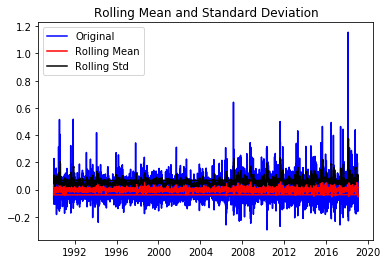

In [13]:
dftest(weekly_vix.vix_close)

In [14]:
# from statsmodels.graphics.gofplots import qqplot
# import scipy.stats as stats
# qqplot(weekly_v.vix_close, fit=True, line='45', dist=stats.t)

## Let's split data up into test and train

In [17]:
from helper import split_data

In [18]:
train, validation, test = split_data(weekly_vix,52)

## Now let's try an AR models

First let's optimize p. I stopped at 15 because it got too slow.

In [19]:
from helper import optimize_ar
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind

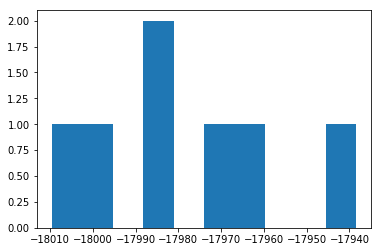

In [20]:
train_ar_params = optimize_ar(train, 8)

In [21]:
train_ar_params

(-18009.601055402418, 7)

Best AIC for AR is 5663 at p=14

## Now let's try an AR models with differencing (ARI?)

In [ ]:
model = ARIMA(train, order=(14,1,0))
model_fit = model.fit()
model_fit.aic

In [ ]:
model = ARIMA(train, order=(14,2,0))
model_fit = model.fit()
model_fit.aic

Model is worse with d at 1 or 2!

## Now let's try an ARIMA model

This function doesn't complete in 5 minutes with my p at 14 and since my difference between p 14 and p 1 was only 20 points out of 6k for AIC I'm going to simplify to p = 1

In [ ]:
#I'm making p smaller to decrease compute time
# aic_res_arima = []
# for i in range(1,5):
#     model = ARIMA(train, order=(1,0,i))
#     model_fit = model.fit()
#     #print(i, model_fit.aic)
#     aic_res_arima.append(model_fit.aic)

In [ ]:
np.array(aic_res_arima).argmin()

In [ ]:
aic_res_arima

MA also don't help, keep Q=0

Seems like my best model is (p,d,q) = (1,0,0) so far with an AIC of 5679.

## Let's try predicting things

In [ ]:
best_model_so_far = ARIMA(train, order=(1,0,0))
best_model_so_far = best_model_so_far.fit()

In [ ]:
best_model_so_far.aic

In [ ]:
prediction = best_model_so_far.forecast()[0][0]

In [ ]:
prediction

In [ ]:
validation['preds'] = best_model_so_far.predict(weekly_vix.shape[0]-52*4, weekly_vix.shape[0]-52*2, dynamic=1)

In [ ]:
validation[['vix_close','preds']].plot()
#validation.plot('vix_close','preds')

Those are some bad predictions! I'm going to look at RMSE as well.

## Reoptimize with RMSE as scoring param

In [23]:
from helper import RMSE
from helper import optimize_ar_rmse

In [29]:
def optimize_ar_rmse_test(df,val,tot, max_p):
    """Takes in timeseries dataframe, outputs optimal p value for ARIMA"""
    rmse = []
    models = []
    for i in range(1,max_p):
        model = ARIMA(df, order=(i,0,0))
        model_fit = model.fit()
        val['preds'] = model_fit.predict(tot.shape[0]-52*4, tot.shape[0]-52*2, dynamic=False)
        models.append(val)
        score = RMSE(val.vix_close.values,val.preds.values)
        rmse.append(score)

In [32]:
model = ARIMA(train, order=(1,0,0)).fit()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind

In [25]:
res = optimize_ar_rmse(train,validation,weekly_vix,4)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind

In [27]:
res[2]

1

In [ ]:
from helper import plot_preds

In [ ]:
plot_preds(train,validation,weekly_vix)

## Too good to be true with fitting on whole model

When I started I had a model that made a really good prediction graph, but it was just based off of predicting on data it already fitted. I'm keeping it for now in the notebook just in case it has some value for me later.

In [ ]:
old_working_model = ARIMA(weekly_vix,order=(1,0,0))
old_working_model = old_working_model.fit()
old_working_model.aic

In [ ]:
weekly_vix.shape

In [ ]:
weekly_vix['preds'] = old_working_model.predict(start = weekly_vix.shape[0]-52*8, end= weekly_vix.shape[0]-52*6, dynamic=False)
weekly_vix[['vix_close','preds']].plot();

Damn that looks good.

In [ ]:
weekly_preds = weekly_vix.iloc[weekly_vix.shape[0]-52*8:weekly_vix.shape[0]-52*6]

In [ ]:
weekly_preds.head()

In [ ]:
RMSE(weekly_preds.vix_close.values,weekly_preds.preds.values)

Twice as good an RMSE score as my really bad models... not sure exactly what to make of that though.

## SARIMA test

In [ ]:
import statsmodels.api as sm

In [ ]:
train.head()

In [ ]:
sar = sm.tsa.statespace.SARIMAX(train, order=(2,0,0), seasonal_order=(0,0,0,12), trend='c').fit()
sar.aic

In [ ]:
pred = sar.get_prediction(weekly_vix.shape[0]-52*4,weekly_vix.shape[0]-52*2)

In [ ]:
validation['preds'] = pred.predicted_mean

In [ ]:
RMSE(validation.vix_close.values,validation.preds.values)

In [ ]:
from helper import MAPE

In [ ]:
MAPE(validation.vix_close.values,validation.preds.values)

In [ ]:
#MAPE(p_validation.y.values,p_validation.preds.values)

In [ ]:
validation[['vix_close','preds']].plot()

I haven't tuned this but I'm not super confident it'll get better.

## Include Exogenous variables (SARIMAX)

In [ ]:
train, validation, test = split_data(vp_df,12)
#I go for monthly data here as my prime rate is only per month

In [ ]:
sar = sm.tsa.statespace.SARIMAX(train['vix_close'], order=(5,2,0), seasonal_order=(0,0,0,12), trend='c').fit()

In [ ]:
sar.aic

Wow, way better AIC on the monthly data!

In [ ]:
sar = sm.tsa.statespace.SARIMAX(train['vix_close'],exog=train['prime_rate'], order=(5,2,0), seasonal_order=(0,0,0,12), trend='c').fit()

In [ ]:
sar.aic

About the same with prime rate as exogenous data

In [ ]:
exog_forecast = validation.loc[:,['prime_rate']]

In [ ]:
pred = sar.get_prediction(vp_df.shape[0]-12*4,vp_df.shape[0]-12*2-1,exog=exog_forecast)

In [ ]:
validation['preds'] = pred.predicted_mean

In [ ]:
RMSE(validation.vix_close.values,validation.preds.values)

In [ ]:
validation[['vix_close','preds']].plot()

RMSE got way worse and graph looks terrible

So far nothing too satisfying, but it all is working. I move on to the Luther Prophet Notebook next to examine the Prophet model from Facebook